# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.cluster import KMeans

from deep_clustering import DeepClustering
from utils.training_and_visualisation import plot_losses, train
from utils.parametric_umap import NumpyToTensorDataset, FastTensorDataLoader, compute_neighbour_matrix, make_neighbor_indices, ContrastiveLoss

from tqdm.notebook import trange




PATH = "embeds/"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [2]:
embs_train = torch.load(PATH + "t5_train.pt")
embs_test = torch.load(PATH + "t5_test.pt")

In [3]:
embs_train.shape

torch.Size([10003, 1024])

In [4]:
embs_train

tensor([[-0.1441,  0.0616,  0.0190,  ..., -0.0876, -0.0151, -0.1390],
        [-0.1633, -0.0161,  0.0720,  ...,  0.0030,  0.0311, -0.1054],
        [-0.0556, -0.0263,  0.0093,  ..., -0.0105, -0.0143, -0.0760],
        ...,
        [-0.1430,  0.0024,  0.0375,  ..., -0.0905,  0.1341,  0.0116],
        [-0.2561,  0.2020,  0.0247,  ..., -0.0581, -0.0733, -0.0380],
        [-0.0799,  0.0132, -0.0034,  ..., -0.0691, -0.0419, -0.0842]])

# Test

## Load dataset

In [5]:
PATH = "../dialogue_data/banking77/"

data_train = pd.read_csv(PATH + "train.csv", sep=",")
texts_train = data_train["text"].to_list()

data_train["cluster"] = data_train["category"].astype("category")
data_train["cluster"] = data_train["cluster"].cat.codes

clusters_train = data_train["cluster"].to_list()

data_test = pd.read_csv(PATH + "test.csv", sep=",")
texts_test = data_test["text"].to_list()

data_test["cluster"] = data_test["category"].astype("category")
data_test["cluster"] = data_test["cluster"].cat.codes

clusters_test = data_test["cluster"].to_list()

data_all = pd.concat((data_train, data_test)).reset_index() # fix indices
clusters_all = clusters_train + clusters_test

# load embeddings
embeds_t5_train = torch.load(PATH + "embeds/t5_train.pt")
embeds_t5_test = torch.load(PATH + "embeds/t5_test.pt")

embeds_t5_all = torch.vstack((embeds_t5_train, embeds_t5_test))
clusters_all = clusters_train + clusters_test

embeds_t5_train.shape, embeds_t5_test.shape

(torch.Size([10003, 1024]), torch.Size([3080, 1024]))

## Take 5 clusters

In [6]:
def sample_clusters(dataframe, raw_embeds, cluster_num_list, noise_cluster_num_list, noise_frac=0.):
    target_idxs = dataframe[dataframe["cluster"].isin(cluster_num_list)].index.to_list()
    target_size = len(target_idxs)
    target_data = dataframe.loc[target_idxs]
    target_embeds = raw_embeds[target_idxs]
    target_clusters = target_data["cluster"].to_list()
                
    if noise_frac != 0. and noise_cluster_num_list is not None:
        non_target_idxs = dataframe[dataframe["cluster"].isin(noise_cluster_num_list)].index.to_list()
        noise_data_all = dataframe.loc[non_target_idxs]

        noise_num = int(noise_frac * target_size)
        noise_idxs = list(np.random.choice(non_target_idxs, noise_num, replace=False))
        noise_data = dataframe.loc[noise_idxs]
        noise_embeds = raw_embeds[noise_idxs]
        noise_clusters = noise_data["cluster"].to_list()
        subset_data = pd.concat((target_data, noise_data))
        subset_clusters = target_clusters + noise_clusters
        subset_embeds = torch.vstack((target_embeds, noise_embeds))
        subset_idxs = target_idxs + noise_idxs
     
        return subset_embeds, subset_idxs, subset_data, subset_clusters, target_idxs
    
    return target_embeds, target_idxs, target_data, target_clusters, target_idxs

In [7]:
base_embeds, base_idxs, base_data, base_clusters, base_idxs_pure = sample_clusters(
    dataframe=data_all,
    raw_embeds=embeds_t5_all,
    cluster_num_list=[0, 1, 2, 3, 4],
    noise_cluster_num_list=None,
    noise_frac=0
)

## Train embeds (Phase 1)

In [8]:
N_ITERS = 100
LR = 3e-2

#model = DeepClustering(3, 2, 2, 14, cluster_centers_init=torch.tensor(kmeans.cluster_centers_)).to(device)
model = DeepClustering(5, 1024, 2, 4, base_embeds, loss_weights=[0.5, 0.5]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
train_dataloader = model.create_dataloader(base_embeds)

In [9]:
losses = train(model, train_dataloader, optimizer, N_ITERS, device)

  0%|          | 0/100 [00:00<?, ?it/s]

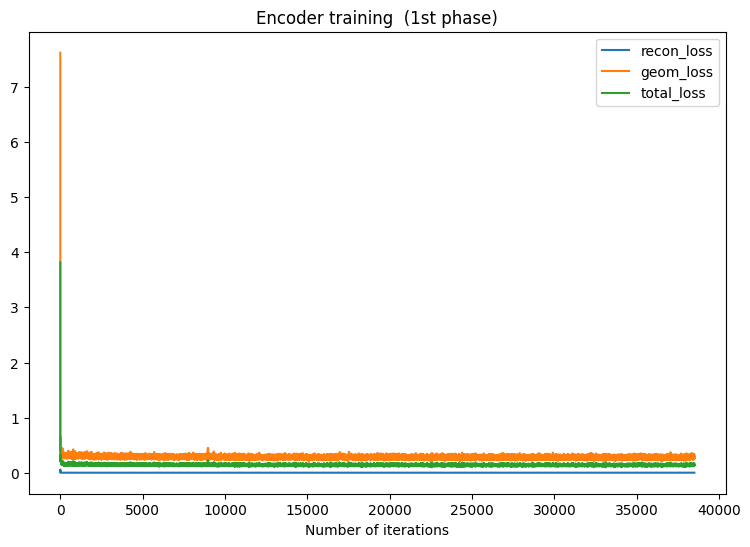

In [10]:
plot_losses(losses, "Encoder training  (1st phase)")

D:\Skoltech\Sber\DeepClusteringForTexts\utils\parametric_umap.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.dataset = torch.tensor(dataset, dtype=torch.float32)


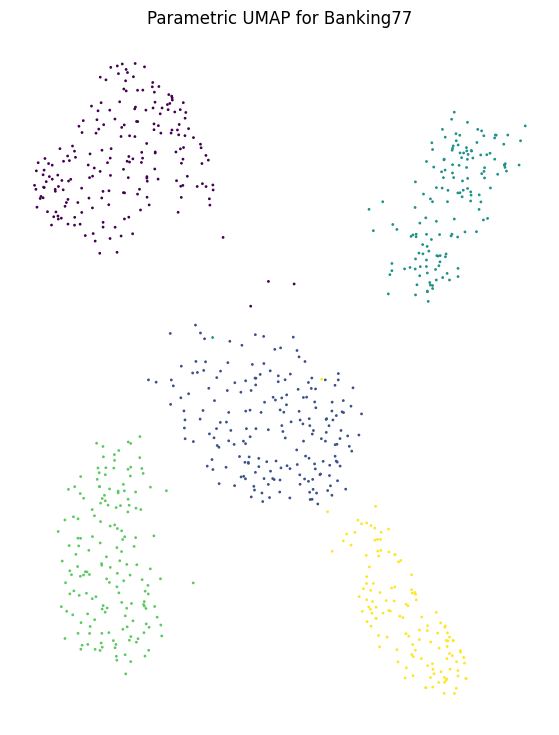

In [11]:
umap_embeds = model.transform(base_embeds.to(device), batch_size=128)

plt.figure(figsize=(9, 9))
plt.scatter(*umap_embeds.T, c=base_clusters, s=1.0)
plt.gca().set_aspect("equal")
plt.axis("off")
plt.title("Parametric UMAP for Banking77")
plt.ylim()
plt.show()

### Save the model

In [13]:
torch.save(model.state_dict(), "../checkpoints/model_after_first_phase.pt")

## Train clusters (Phase 2)

### Load a model state from checkpoint

In [44]:
model = DeepClustering(5, 1024, 2, 4, base_embeds, loss_weights=[0.5, 0.5]).to(device)
model.load_state_dict(torch.load("../checkpoints/model_after_first_phase.pt"))

<All keys matched successfully>

In [45]:
N_ITERS = 2
LR = 3e-2

# Change mode of the model to `train_clusters` and change weights of losses:
model.train_clusters(base_embeds.to(device), [0., 0.2, 0.8]) 
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [46]:
init_centers = model.centers.cpu().detach().numpy()

In [47]:
losses = train(model, train_dataloader, optimizer, N_ITERS, device)

  0%|          | 0/2 [00:00<?, ?it/s]

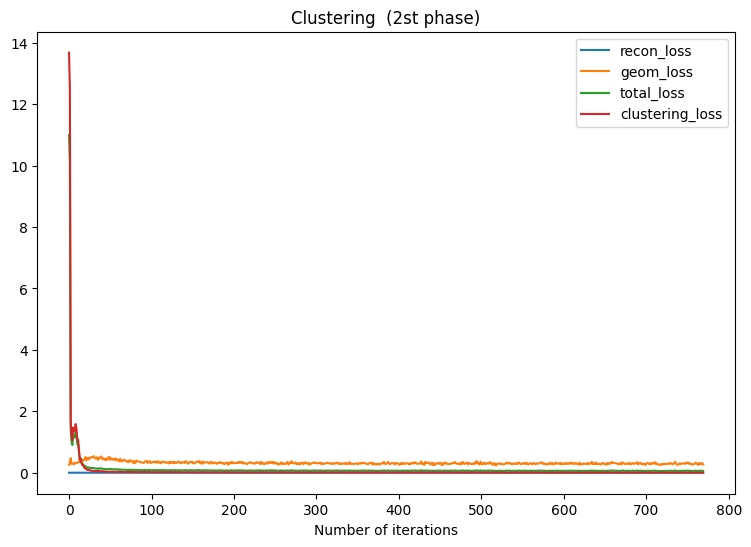

In [48]:
plot_losses(losses, "Clustering  (2st phase)")

In [49]:
model.centers

Parameter containing:
tensor([[ 10.8625,  -9.1844],
        [ 10.5160, -17.3171],
        [  8.0168, -12.8496],
        [  6.4621,  -9.1009],
        [  4.8263, -16.2142]], device='cuda:0', dtype=torch.float64,
       requires_grad=True)

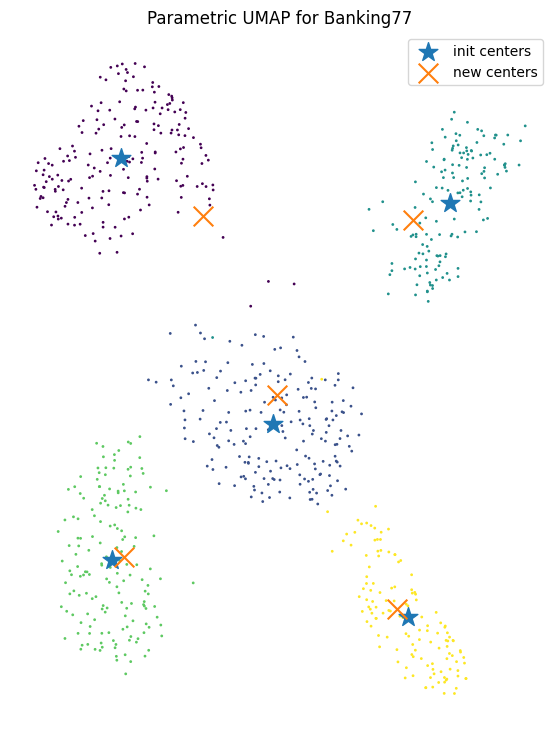

In [50]:
new_centers = model.centers.cpu().detach().numpy()

plt.figure(figsize=(9, 9))
plt.scatter(*umap_embeds.T, c=base_clusters, s=1.0)
plt.scatter(init_centers[:, 0], init_centers[:, 1], marker='*', label='init centers', s=200)
plt.scatter(new_centers[:, 0], new_centers[:, 1], marker='x', label='new centers', s=200)
plt.gca().set_aspect("equal")
plt.axis("off")
plt.title("Parametric UMAP for Banking77")
plt.legend()
plt.show()


#plt.xlim(-100, 100)
#plt.ylim(-100, 100)
#plt.show()